<a href="https://colab.research.google.com/github/LvJiaaaaY/Stock-Prediction-Project/blob/main/transformer%5BDataFrame%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
import math
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as pyplot
import torch
import torch.nn as nn
import seaborn
import time

torch.manual_seed(0)
np.random.seed(0)

calculate_loss_over_all_values = False

from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   AMT        EQIX         PSA     SPG-PJ
Date                                                     
2023-07-27  193.229996  796.070007  288.329987  59.318901
2023-07-28  188.970001  797.359985  281.529999  58.759998
2023-07-31  190.309998  809.919983  281.750000  59.375198
2023-08-01  191.240005  805.159973  279.350006  59.000000
2023-08-02  190.619995  805.630005  278.769989  57.599998


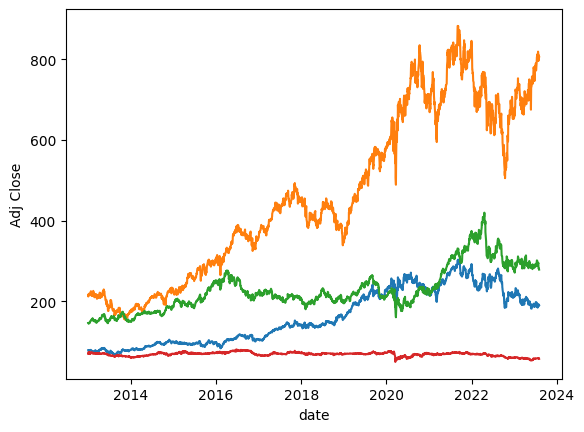

In [229]:
# Parameter for data
# Start Date
start_date='2013-01-01'
## End Date
end_date='2023-08-03'
## Split ratio of train data and validation data
train_rate=0.8
## How many business days to see
input_window=100
## How many business days to predict
output_window=5

# Parameter for mdoel
batch_size=64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#多个股票同时输入
code_list=['AMT',"EQIX",'PSA','SPG-PJ']#,'PLD'
data_list =[]
for code in code_list:
  data = wb.DataReader(code,start=start_date,end=end_date)['Close'].to_frame()
  data.rename(columns={'Close':code}, inplace = True)
  data_list.append(data)#获取的第二个股票数据接在第一个股票的右边
data = pd.concat(data_list,axis = 1)
print(data.tail())

plt.plot(data)
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.show()

In [230]:
mean_list=data.mean().values
std_list=data.std().values
data=(data-mean_list)/std_list
data

,AMT,EQIX,PSA,SPG-PJ
Date,,,,
2013-01-02,-1.219379,-1.196958,-1.523207,0.261038
2013-01-03,-1.248019,-1.210970,-1.533117,0.261038
2013-01-04,-1.249058,-1.195750,-1.520821,0.454898
2013-01-07,-1.250394,-1.178742,-1.525776,1.156586
2013-01-08,-1.245793,-1.195992,-1.543945,0.455108
...,...,...,...,...
2023-07-27,0.475012,1.610595,1.087299,-2.006509
2023-07-28,0.411795,1.616828,0.962500,-2.124279
2023-07-31,0.431680,1.677516,0.966538,-1.994646


In [231]:
# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    # print(L)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw,:][:-output_window,:] , np.zeros((output_window,4)),axis=0)
        train_label = input_data[i:i+tw,:]
        # print(train_seq.shape,train_label.shape)
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

def get_data(data):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #data = data_.loc[(data_["date"] >= pd.Timestamp(date(2014, 1, 1))) & (data_["date"] <= pd.Timestamp(date(2014, 2, 10)))]
    #data = data.loc[:, "MT_200":  "MT_209"]
    series = data.to_numpy()
    # print('a',series.shape)
    amplitude = scaler.fit_transform(series)
    # print('b', amplitude.shape)
    # amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    # print(amplitude.shape)
    samples = int(np.shape(data)[0]*train_rate)
    train_data = amplitude[:samples]
    test_data = amplitude[samples:]

    # print(train_data.shape,test_data.shape)
    # convert our train data into a pytorch train tensor
    # train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment..
    # print('c',train_data.shape)

    train_sequence = create_inout_sequences(train_data,input_window)
    # print('a',train_sequence.size())
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1)
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device),test_data.to(device),scaler

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)).squeeze()# 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1)).squeeze()
    return input, target

In [232]:
train_data, val_data,scaler = get_data(data)
print(train_data.size())
# print(train_data.size(), val_data.size())
tr,te = get_batch(train_data, 0,batch_size)
print(tr.shape,te.shape)

torch.Size([2026, 2, 100, 4])
torch.Size([100, 64, 4]) torch.Size([100, 64, 4])


In [233]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):

        return x + self.pe[:x.size(0), :]

In [234]:
class TransAm(nn.Module):
    def __init__(self,feature_size=4,num_layers=3,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=4, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        #self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            # print('a',src.size())
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        # print('j',src.size(),self.src_mask.size())
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)

        output = self.decoder(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [235]:
def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [236]:
def plot_and_loss(eval_model, data_source,epoch,scaler):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)

            # look like the model returns static values for the output window
            output = eval_model(data)

            if calculate_loss_over_all_values:
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()


            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)

    #test_result = test_result.cpu().numpy()
    len(test_result)

    print(test_result.size(),truth.size())
    test_result=scaler.inverse_transform(test_result.reshape(-1, 1)).reshape(-1)
    truth=scaler.inverse_transform(truth.reshape(-1, 1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.axhline(y=0, color='k')
    pyplot.xlabel("Periods")
    pyplot.ylabel("Y")
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    return total_loss / i


def predict_future(eval_model, data_source,steps,epoch,scaler):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0
            output = eval_model(data[-input_window:])
            data = torch.cat((data, output[-1:]))

    data = data.cpu().view(-1)

    data=scaler.inverse_transform(data.reshape(-1, 1)).reshape(-1)
    pyplot.plot(data,color="red")
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%epoch)
    pyplot.close()

# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)
            print(output[-output_window:].size(),targets[-output_window:].size())
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()
    return total_loss / len(data_source)

In [237]:

def plot(eval_model, data_source,epoch,scaler):
    eval_model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            data = data.unsqueeze(1)
            target = target.unsqueeze(1)
            # look like the model returns static values for the output window
            output = eval_model(data)
            if calculate_loss_over_all_values:
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()

            test_result = torch.cat((test_result, output[-1,:].squeeze(1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1,:].squeeze(1).cpu()), 0)

    #test_result = test_result.cpu().numpy()
    len(test_result)

    test_result_=scaler.inverse_transform(test_result[:700])
    truth_=scaler.inverse_transform(truth)
    print(test_result.shape,truth.shape)
    for m in range(4):
        test_result = test_result_[:,m]
        truth = truth_[:,m]
        fig = pyplot.figure(1, figsize=(20, 5))
        fig.patch.set_facecolor('xkcd:white')
        pyplot.plot([k + 310 for k in range(117)],test_result[310:],color="red")
        pyplot.title('Prediction uncertainty')
        pyplot.plot(truth[:700],color="black")
        pyplot.legend(["prediction", "true"], loc="upper left")
        ymin, ymax = pyplot.ylim()
        pyplot.vlines(310, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        pyplot.ylim(ymin, ymax)
        pyplot.xlabel("Periods")
        pyplot.ylabel("Price")
        pyplot.show()
        pyplot.close()
    return total_loss / i

<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-238-2104c0c0c04f>:19: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(epoch % 1 is 0):
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     6/   31 batches | lr 0.050000 | 1345.46 ms | loss 0.33138 | ppl     1.39
| epoch   1 |    12/   31 batches | lr 0.050000 | 1140.51 ms | loss 0.03815 | ppl     1.04
| epoch   1 |    18/   31 batches | lr 0.050000 | 1099.04 ms | loss 0.05854 | ppl     1.06
| epoch   1 |    24/   31 batches | lr 0.050000 | 1143.73 ms | loss 0.04807 | ppl     1.05
| epoch   1 |    30/   31 batches | lr 0.050000 | 1154.45 ms | loss 0.09161 | ppl     1.10
torch.Size([427, 4]) torch.Size([427, 4])


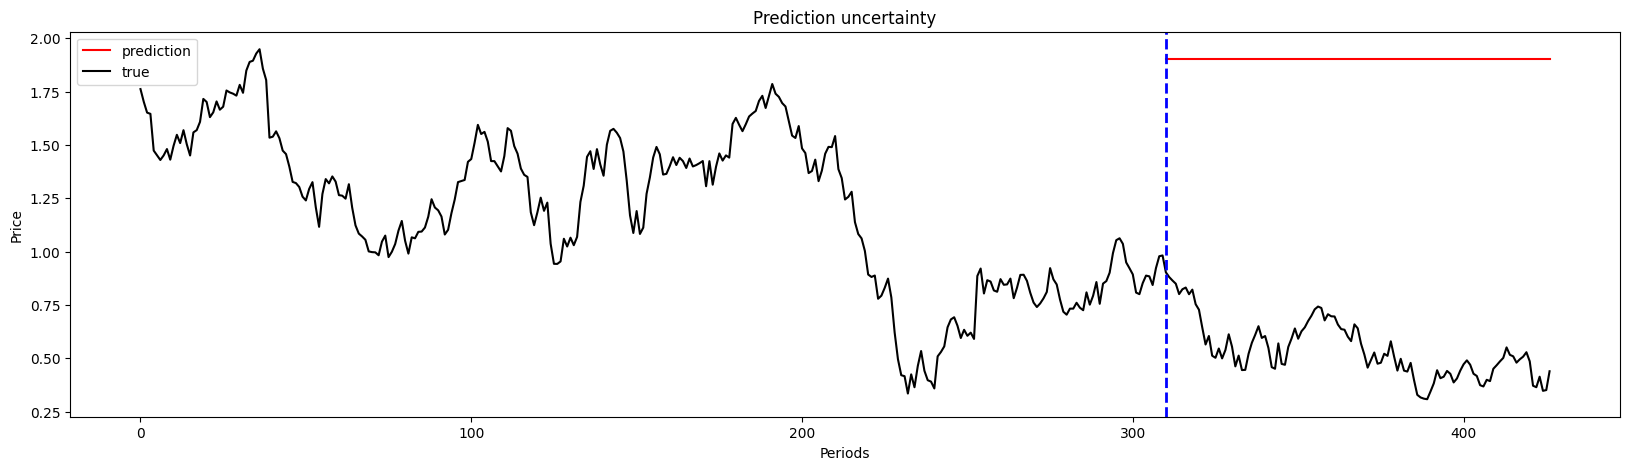

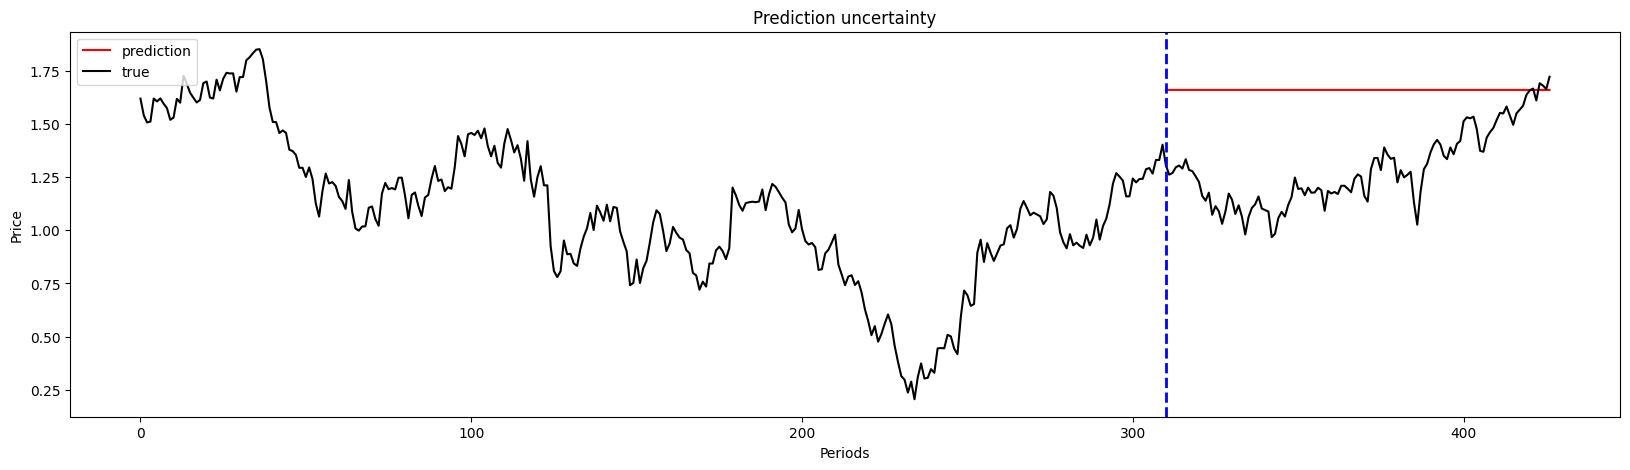

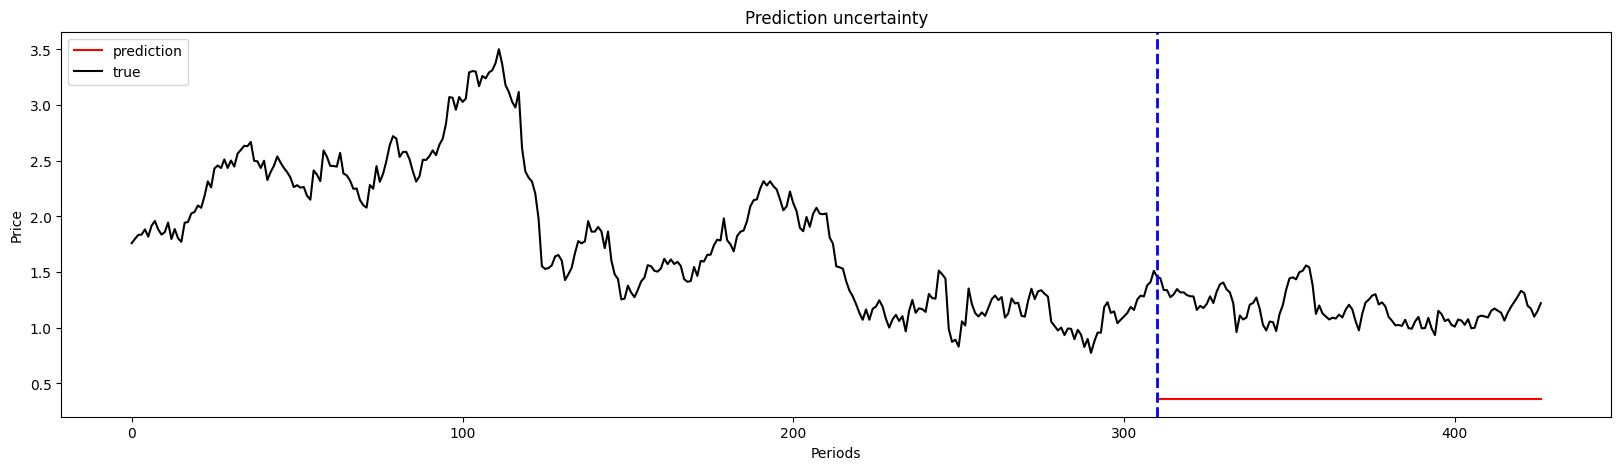

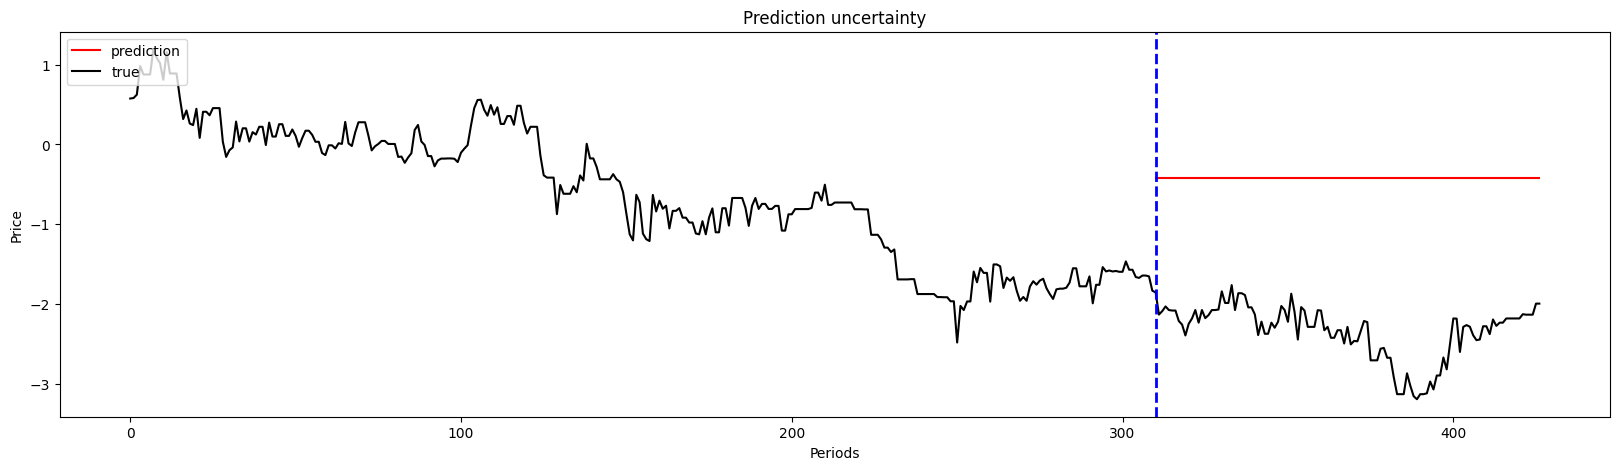

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 38.46s | valid loss 0.22719 | valid ppl     1.26
-----------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   2 |     6/   31 batches | lr 0.048020 | 1294.72 ms | loss 1.12100 | ppl     3.07
| epoch   2 |    12/   31 batches | lr 0.048020 | 1150.87 ms | loss 0.11936 | ppl     1.13
| epoch   2 |    18/   31 batches | lr 0.048020 | 1155.18 ms | loss 0.10302 | ppl     1.11
| epoch   2 |    24/   31 batches | lr 0.048020 | 1101.54 ms | loss 0.03268 | ppl     1.03


In [ ]:
train_data, val_data,scaler = get_data(data)
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)


    if(epoch % 1 is 0):
        val_loss = plot(model, val_data,epoch,scaler)
        # predict_future(model, val_data,200,epoch,scaler)
    else:
        val_loss = evaluate(model, val_data)

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step()